In [1]:
import os
import logging
import pandas as pd
import numpy as np
import lightgbm as lgb
from models.data_loader import data_loader, data_loader_all
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss

pd.options.display.max_columns = 50

In [2]:
train = pd.read_csv('input/train.csv', index_col='id')
test = pd.read_csv('input/test.csv', index_col='id')
sub = pd.read_csv('input/sample_submission.csv')
print(train.shape, test.shape)

(199991, 22) (10009, 21)


In [3]:
train.head()

,type,fiberID,psfMag_u,psfMag_g,psfMag_r,psfMag_i,psfMag_z,fiberMag_u,fiberMag_g,fiberMag_r,fiberMag_i,fiberMag_z,petroMag_u,petroMag_g,petroMag_r,petroMag_i,petroMag_z,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z
id,,,,,,,,,,,,,,,,,,,,,,
0,QSO,601,23.198224,21.431953,21.314148,21.176553,21.171444,22.581309,21.644453,21.657571,21.387653,21.572827,22.504317,21.431636,21.478312,21.145409,20.422446,22.749241,21.465534,21.364187,21.020605,21.147340
1,QSO,788,21.431355,20.708104,20.678850,20.703420,20.473229,21.868797,21.029773,20.967054,20.937731,21.063646,21.360701,20.778968,20.889705,20.639812,20.646660,21.492955,20.758527,20.753925,20.693389,20.512314
2,QSO,427,17.851451,16.727898,16.679677,16.694640,16.641788,18.171890,17.033098,16.999682,17.095999,17.076449,17.867253,16.738784,16.688874,16.744210,16.808006,17.818063,16.697434,16.641249,16.660177,16.688928
3,QSO,864,20.789900,20.040371,19.926909,19.843840,19.463270,21.039030,20.317165,20.217898,20.073852,19.794505,20.433907,19.993727,19.985531,19.750917,19.455117,20.770711,20.001699,19.889798,19.758113,19.552855
4,STAR_RED_DWARF,612,26.454969,23.058767,21.471406,19.504961,18.389096,25.700632,23.629122,21.742750,19.861718,18.810375,25.859229,22.426929,21.673551,19.610012,18.376141,24.877052,23.147993,21.475342,19.487330,18.375655


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199991 entries, 0 to 199990
Data columns (total 22 columns):
type          199991 non-null object
fiberID       199991 non-null int64
psfMag_u      199991 non-null float64
psfMag_g      199991 non-null float64
psfMag_r      199991 non-null float64
psfMag_i      199991 non-null float64
psfMag_z      199991 non-null float64
fiberMag_u    199991 non-null float64
fiberMag_g    199991 non-null float64
fiberMag_r    199991 non-null float64
fiberMag_i    199991 non-null float64
fiberMag_z    199991 non-null float64
petroMag_u    199991 non-null float64
petroMag_g    199991 non-null float64
petroMag_r    199991 non-null float64
petroMag_i    199991 non-null float64
petroMag_z    199991 non-null float64
modelMag_u    199991 non-null float64
modelMag_g    199991 non-null float64
modelMag_r    199991 non-null float64
modelMag_i    199991 non-null float64
modelMag_z    199991 non-null float64
dtypes: float64(20), int64(1), object(1)
memory usage: 3

In [5]:
train['type'].value_counts()

QSO                    49680
GALAXY                 37347
SERENDIPITY_BLUE       21760
SPECTROPHOTO_STD       14630
REDDEN_STD             14618
STAR_RED_DWARF         13750
STAR_BHB               13500
SERENDIPITY_FIRST       7132
ROSAT_D                 6580
STAR_CATY_VAR           6506
SERENDIPITY_DISTANT     4654
STAR_CARBON             3257
SERENDIPITY_RED         2562
STAR_WHITE_DWARF        2160
STAR_SUB_DWARF          1154
STAR_BROWN_DWARF         500
SKY                      127
SERENDIPITY_MANUAL        61
STAR_PN                   13
Name: type, dtype: int64

In [6]:
train.isnull().sum()

type          0
fiberID       0
psfMag_u      0
psfMag_g      0
psfMag_r      0
psfMag_i      0
psfMag_z      0
fiberMag_u    0
fiberMag_g    0
fiberMag_r    0
fiberMag_i    0
fiberMag_z    0
petroMag_u    0
petroMag_g    0
petroMag_r    0
petroMag_i    0
petroMag_z    0
modelMag_u    0
modelMag_g    0
modelMag_r    0
modelMag_i    0
modelMag_z    0
dtype: int64

In [7]:
# object_columns = train.select_dtypes(include=['object']).columns.tolist()
# print(object_columns[:5], len(object_columns))

In [8]:
# train = train.fillna(0)
# test = test.fillna(0)

In [9]:
truth = [col for col in sub.columns if col != 'id']
truth

['STAR_WHITE_DWARF',
 'STAR_CATY_VAR',
 'STAR_BROWN_DWARF',
 'SERENDIPITY_RED',
 'REDDEN_STD',
 'STAR_BHB',
 'GALAXY',
 'SERENDIPITY_DISTANT',
 'QSO',
 'SKY',
 'STAR_RED_DWARF',
 'ROSAT_D',
 'STAR_PN',
 'SERENDIPITY_FIRST',
 'STAR_CARBON',
 'SPECTROPHOTO_STD',
 'STAR_SUB_DWARF',
 'SERENDIPITY_MANUAL',
 'SERENDIPITY_BLUE']

In [10]:
# labels = dict(zip(train['type'].unique().tolist(), list(range(train['type'].nunique()))))
labels = dict(zip(truth, list(range(len(truth)))))
labels

{'STAR_WHITE_DWARF': 0,
 'STAR_CATY_VAR': 1,
 'STAR_BROWN_DWARF': 2,
 'SERENDIPITY_RED': 3,
 'REDDEN_STD': 4,
 'STAR_BHB': 5,
 'GALAXY': 6,
 'SERENDIPITY_DISTANT': 7,
 'QSO': 8,
 'SKY': 9,
 'STAR_RED_DWARF': 10,
 'ROSAT_D': 11,
 'STAR_PN': 12,
 'SERENDIPITY_FIRST': 13,
 'STAR_CARBON': 14,
 'SPECTROPHOTO_STD': 15,
 'STAR_SUB_DWARF': 16,
 'SERENDIPITY_MANUAL': 17,
 'SERENDIPITY_BLUE': 18}

In [11]:
X = train.drop(['type'], axis=1).values
y = train['type'].replace(labels).values
# y = train['label'].values
# test = test.drop(, axis=1).values

In [12]:
n_class = train['type'].nunique()
print(n_class)

19


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

np.random.seed(42)

train_preds = np.zeros((len(X), n_class))
test_preds = np.zeros((len(test), n_class))
cv_score = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
    X_train_data = X[train_index]
    X_valid_data = X[valid_index]
    y_train_data = y[train_index]
    y_valid_data = y[valid_index]
        
    clf = RandomForestClassifier(n_estimators=100, max_depth=None, n_jobs=-1, random_state=42)
    clf.fit(X_train_data, y_train_data)
    
    preds = clf.predict_proba(X_valid_data)
    
    train_preds[valid_index] = preds
    test_preds += clf.predict_proba(test.values) / skf.n_splits

    score = log_loss(y_valid_data, preds)
    acc = accuracy_score(y_valid_data, np.argmax(preds, axis=1))
    
    print('{}-fold: logloss = {:.5f} acc = {:.5f}'.format(i+1, score, acc))
    
    cv_score.append(score)

print('\ntrain accuracy score = {:.3}'.format(accuracy_score(y, np.argmax(train_preds, axis=1))))
print('logloss {}'.format(np.mean(cv_score)))

1-fold: logloss = 0.48218 acc = 0.87996


KeyboardInterrupt: 

In [27]:
# n_estimators 200, max_depth=None 0.43327
# 200, 0.430
# 250, 0.423
# 300, 0.416
# 400, 0.407
# 500, 0.402
# 600, 0.396
# 800, 0.391
# 1000, 0.388 -> 0.408
# 1300, 

In [28]:
sub.iloc[:, 1:] = test_preds
sub.to_csv('submission-2.csv', index=False)

In [15]:
clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [78]:
(len(train)/5) / (19 * np.bincount(y))

array([9.74615010e-01, 3.23573382e-01, 4.21033684e+00, 8.21689470e-01,
       1.44012069e-01, 1.55938402e-01, 5.63678052e-02, 4.52335286e-01,
       4.23745656e-02, 1.65761293e+01, 1.53103158e-01, 3.19934410e-01,
       1.61936032e+02, 2.95172241e-01, 6.46351987e-01, 1.43893945e-01,
       1.82423607e+00, 3.45109577e+01, 9.67448723e-02])

In [74]:
params = {
    'boosting': 'dart', # gbdt
    'objective': 'multiclass',
    'num_class': n_class,
    'metric': 'multi_logloss', # multi_logloss
    'learning_rate': 0.1,
    'num_leaves': 500, # default 31
    'max_depth': 0, # -1
    'min_data_in_leaf': 1,
    'bagging_fraction': 1.0, # important
#     'pos_bagging_fraction': 1.0,
#     'neg_bagging_fraction': 1.0,
    'min_gain_to_split': 2,
    'bagging_freq': 1000, # rf bf > 0, default 0 # important
#     'bagging_seed': 3,
#     'feature_fraction': 1.0,
#     'feature_fraction_bynode': 1.0,
#     'feature_fraction_seed': 2,
#     'max_delta_step': 0.0,
#     'lambda_l1': 0.0,
#     'lambda_l2': 0.0,
    'device_type': 'cpu', # gpu
    'seed': 42,
   'num_threads': -1,
    'verbosity': -1,
    }

In [75]:
train_preds = np.zeros((len(X), n_class))
test_preds = np.zeros((len(test), n_class))
cv_score = []
best_trees = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
    X_train_data = X[train_index]
    X_valid_data = X[valid_index]
    y_train_data = y[train_index]
    y_valid_data = y[valid_index]
    
    dtrain = lgb.Dataset(X_train_data, y_train_data)
    dvalid = lgb.Dataset(X_valid_data, y_valid_data)
    
    bst = lgb.train(params, 
                     dtrain, 
                     num_boost_round=300, 
                     valid_sets=[dtrain, dvalid], 
                     verbose_eval=False,
                     early_stopping_rounds=None)
    
    best_trees.append(bst.best_iteration)
    preds = bst.predict(X_valid_data)
    
    train_preds[valid_index] = preds
    test_preds += bst.predict(test.values, num_iteration=bst.best_iteration) / skf.n_splits
    
#     clf.fit(X_train_data, y_train_data)
    score = log_loss(y_valid_data, preds)
    acc = accuracy_score(y_valid_data, np.argmax(preds, axis=1))
    
    print('{}-fold: logloss = {:.5f} acc = {:.5f}'.format(i+1, score, acc))
    
    cv_score.append(score)
#     train_preds[valid_index] = clf.predict_proba(X_valid_data)
#     test_preds += clf.predict_proba(test.values) / skf.n_splits

# print('\ntrain accuracy score = {:.3}'.format(accuracy_score(y, np.argmax(train_preds, axis=1))))
# print('train f1 score = {}'.format(f1_score(y, np.argmax(train_preds, axis=1), average=None)))

1-fold: logloss = 0.44401 acc = 0.87061


KeyboardInterrupt: 

In [ ]:
sub.head()

In [ ]:
sub.iloc[:, 1:] = test_preds

sub.to_csv('submission.csv', index=False)

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
train_preds = np.zeros((len(X), n_class))
test_preds = np.zeros((len(test), n_class))
cv_score = []
best_trees = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
    X_train_data = X[train_index]
    X_valid_data = X[valid_index]
    y_train_data = y[train_index]
    y_valid_data = y[valid_index]
    
    dtrain = lgb.Dataset(X_train_data, y_train_data)
    dvalid = lgb.Dataset(X_valid_data, y_valid_data)
    
    clf = LogisticRegression(solver='lbfgs', max_iter=100, multi_class='auto', n_jobs=-1)
    clf.fit(X_train_data, y_train_data)
    
    preds = clf.predict_proba(X_valid_data)
    
    train_preds[valid_index] = preds
    test_preds += clf.predict_proba(test.values) / skf.n_splits
    
#     clf.fit(X_train_data, y_train_data)
    score = log_loss(y_valid_data, preds)
    acc = accuracy_score(y_valid_data, np.argmax(preds, axis=1))
    
    print('{}-fold: logloss = {:.5f} acc = {:.5f}'.format(i+1, score, acc))
    
    cv_score.append(score)
#     train_preds[valid_index] = clf.predict_proba(X_valid_data)
#     test_preds += clf.predict_proba(test.values) / skf.n_splits

# print('\ntrain accuracy score = {:.3}'.format(accuracy_score(y, np.argmax(train_preds, axis=1))))
# print('train f1 score = {}'.format(f1_score(y, np.argmax(train_preds, axis=1), average=None)))

In [87]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
train_preds = np.zeros((len(X), n_class))
test_preds = np.zeros((len(test), n_class))
cv_score = []
best_trees = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
    X_train_data = X[train_index]
    X_valid_data = X[valid_index]
    y_train_data = y[train_index]
    y_valid_data = y[valid_index]
    
    dtrain = lgb.Dataset(X_train_data, y_train_data)
    dvalid = lgb.Dataset(X_valid_data, y_valid_data)
    
    clf = KNeighborsClassifier(n_neighbors=n_class, n_jobs=-1)
    clf.fit(X_train_data, y_train_data)
    
    preds = clf.predict_proba(X_valid_data)
    
    train_preds[valid_index] = preds
    test_preds += clf.predict_proba(test.values) / skf.n_splits
    
#     clf.fit(X_train_data, y_train_data)
    score = log_loss(y_valid_data, preds)
    acc = accuracy_score(y_valid_data, np.argmax(preds, axis=1))
    
    print('{}-fold: logloss = {:.5f} acc = {:.5f}'.format(i+1, score, acc))
    
    cv_score.append(score)
#     train_preds[valid_index] = clf.predict_proba(X_valid_data)
#     test_preds += clf.predict_proba(test.values) / skf.n_splits

# print('\ntrain accuracy score = {:.3}'.format(accuracy_score(y, np.argmax(train_preds, axis=1))))
# print('train f1 score = {}'.format(f1_score(y, np.argmax(train_preds, axis=1), average=None)))

In [ ]:
from sklearn.svm import SVC

In [ ]:
train_preds = np.zeros((len(X), n_class))
test_preds = np.zeros((len(test), n_class))
cv_score = []
best_trees = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
    X_train_data = X[train_index]
    X_valid_data = X[valid_index]
    y_train_data = y[train_index]
    y_valid_data = y[valid_index]
    
    dtrain = lgb.Dataset(X_train_data, y_train_data)
    dvalid = lgb.Dataset(X_valid_data, y_valid_data)
    
    clf = SVC(random_state=42)
    clf.fit(X_train_data, y_train_data)
    
    preds = clf.predict_proba(X_valid_data)
    
    train_preds[valid_index] = preds
    test_preds += clf.predict_proba(test.values) / skf.n_splits
    
#     clf.fit(X_train_data, y_train_data)
    score = log_loss(y_valid_data, preds)
    acc = accuracy_score(y_valid_data, np.argmax(preds, axis=1))
    
    print('{}-fold: logloss = {:.5f} acc = {:.5f}'.format(i+1, score, acc))
    
    cv_score.append(score)
#     train_preds[valid_index] = clf.predict_proba(X_valid_data)
#     test_preds += clf.predict_proba(test.values) / skf.n_splits

# print('\ntrain accuracy score = {:.3}'.format(accuracy_score(y, np.argmax(train_preds, axis=1))))
# print('train f1 score = {}'.format(f1_score(y, np.argmax(train_preds, axis=1), average=None)))

In [ ]:
import logging

1-fold: logloss = 0.44969 acc = 0.88101
2-fold: logloss = 0.44369 acc = 0.87948
3-fold: logloss = 0.45271 acc = 0.87942


KeyboardInterrupt: 

In [42]:
sub.iloc[:, 1:] = test_preds
sub.to_csv('submission-2.csv', index=False)

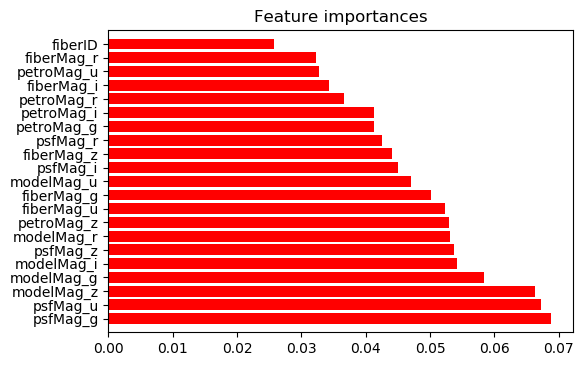

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline

importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure(dpi=100)
plt.title("Feature importances")
plt.barh(range(X.shape[1]), importances[indices],
       color="r", align="center") # xerr=std[indices], 

plt.yticks(range(X.shape[1]), train.drop(['type'], axis=1).columns[indices]) #rotation
# plt.xlabels(train.columns[indices])
plt.ylim([-1, X.shape[1]])
plt.show()

In [53]:
indices

array([ 2,  1, 20, 17, 19,  5, 18, 15,  6,  7, 16,  4, 10,  3, 12, 14, 13,
        9, 11,  8,  0])

In [ ]:
from sklearn.base import BaseEstimator


class OutOfFold(BaseEstimator):
    def __init__(self, model, n_folds=5):
        self.model = model
        self.n_folds = n_folds
   
    def fit(self, X, y):
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        train_preds = np.zeros((len(X), n_class))

        for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
            X_train_data = X[train_index]
            X_valid_data = X[valid_index]
            y_train_data = y[train_index]
            y_valid_data = y[valid_index]

            self.model.fit(X_train_data, y_train_data)

            preds = self.model.predict_proba(X_valid_data)

            train_preds[valid_index] = preds

            score = log_loss(y_valid_data, preds)
            acc = accuracy_score(y_valid_data, np.argmax(preds, axis=1))

            print('{}-fold: logloss = {:.5f} acc = {:.5f}'.format(i+1, score, acc))
        
        return self
   
    def predict(self, X):
        return self.model.predict_proba(X)

In [116]:
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

np.random.seed(42)

# Alternatively X and y can be obtained directly from the frame attribute:
# X = titanic.frame.drop('survived', axis=1)
# y = titanic.frame['survived']

# We will train our classifier with the following features:
# Numeric Features:
# - age: float.
# - fare: float.
# Categorical Features:
# - embarked: categories encoded as strings {'C', 'S', 'Q'}.
# - sex: categories encoded as strings {'female', 'male'}.
# - pclass: ordinal integers {1, 2, 3}.

# We create the preprocessing pipelines for both numeric and categorical data.
numeric_features = train.select_dtypes(include=['float']).columns.tolist()
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
oof = OutOfFold(RandomForestClassifier(n_estimators=200, max_depth=None, n_jobs=-1, random_state=42))
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', oof)])

# X is numpy, so we input dataframe
clf.fit(train.drop(['type'], axis=1), y)

1-fold: logloss = 0.45596 acc = 0.87099
2-fold: logloss = 0.46571 acc = 0.87116
3-fold: logloss = 0.45543 acc = 0.87107
4-fold: logloss = 0.46158 acc = 0.86976
5-fold: logloss = 0.44850 acc = 0.86968


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                             

In [90]:
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin, clone

In [112]:
from sklearn.base import BaseEstimator


class OutOfFold(BaseEstimator):
    def __init__(self, model, n_folds=5):
        self.model = model
        self.n_folds = n_folds
   
    def fit(self, X, y):
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        train_preds = np.zeros((len(X), n_class))

        for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
            X_train_data = X[train_index]
            X_valid_data = X[valid_index]
            y_train_data = y[train_index]
            y_valid_data = y[valid_index]

            self.model.fit(X_train_data, y_train_data)

            preds = self.model.predict_proba(X_valid_data)

            train_preds[valid_index] = preds

            score = log_loss(y_valid_data, preds)
            acc = accuracy_score(y_valid_data, np.argmax(preds, axis=1))

            print('{}-fold: logloss = {:.5f} acc = {:.5f}'.format(i+1, score, acc))
        
        return self
   
    def predict(self, X):
        return self.model.predict_proba(X)

In [113]:
oof = OutOfFold(RandomForestClassifier(n_estimators=150, max_depth=None, n_jobs=-1, random_state=42))
oof.fit(X, y)

1-fold: logloss = 0.44969 acc = 0.88101
2-fold: logloss = 0.44369 acc = 0.87948
3-fold: logloss = 0.45271 acc = 0.87942
4-fold: logloss = 0.45187 acc = 0.87691


KeyboardInterrupt: 

In [103]:
class StackingAveragedModels(BaseEstimator, ClassifierMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
#         kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((len(X), len(self.base_models)))
        train_preds = np.zeros((len(X), n_class))
        for i, model in enumerate(self.base_models):
            for train_index, valid_index in skf.split(X, y):
                instance = clone(model)
                X_train_data = X[train_index]
                X_valid_data = X[valid_index]
                y_train_data = y[train_index]
                y_valid_data = y[valid_index]
                
                self.base_models_[i].append(instance)
                instance.fit(X_train_data, y_train_data)
                
                preds = instance.predict_proba(X_valid_data)
    
                train_preds[valid_index] = preds
                
                score = log_loss(y_valid_data, preds)
                acc = accuracy_score(y_valid_data, np.argmax(preds, axis=1))

                print('{}-fold: logloss = {:.5f} acc = {:.5f}'.format(i+1, score, acc))
#                 y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[valid_index, i] = instance.predict(X_valid_data)
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        
        return self
   
    # Do the predictions of all base models on the test data and use the averaged predictions as 
    # meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        
        return self.meta_model_.predict(meta_features)

In [104]:
stacked_averaged_models = StackingAveragedModels(base_models=(RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42), KNeighborsClassifier(n_neighbors=n_class, n_jobs=-1)),
                                                 meta_model=RandomForestClassifier())

In [106]:
stacked_averaged_models.predict(X)

array([ 8,  8,  7, ..., 10,  6,  8])

In [105]:
stacked_averaged_models.fit(X, y)

1-fold: logloss = 0.48218 acc = 0.87996
1-fold: logloss = 0.48401 acc = 0.87968
1-fold: logloss = 0.48645 acc = 0.87917
1-fold: logloss = 0.48105 acc = 0.87613
1-fold: logloss = 0.48609 acc = 0.87703
2-fold: logloss = 1.74271 acc = 0.76510
2-fold: logloss = 1.77588 acc = 0.76646
2-fold: logloss = 1.72276 acc = 0.76821
2-fold: logloss = 1.73096 acc = 0.76420
2-fold: logloss = 1.74781 acc = 0.76246


/Users/unerue/anaconda3/envs/kaggle/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


StackingAveragedModels(base_models=(RandomForestClassifier(bootstrap=True,
                                                           class_weight=None,
                                                           criterion='gini',
                                                           max_depth=None,
                                                           max_features='auto',
                                                           max_leaf_nodes=None,
                                                           min_impurity_decrease=0.0,
                                                           min_impurity_split=None,
                                                           min_samples_leaf=1,
                                                           min_samples_split=2,
                                                           min_weight_fraction_leaf=0.0,
                                                           n_estimators=100,
                                        

In [82]:
train_preds = np.zeros((len(X), n_class))
test_preds = np.zeros((len(test), n_class))
cv_score = []
best_trees = []

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
    X_train_data = X[train_index]
    X_valid_data = X[valid_index]
    y_train_data = y[train_index]
    y_valid_data = y[valid_index]
    
    clf = RandomForestClassifier(n_estimators=150, max_depth=None, n_jobs=-1, random_state=42)
    clf.fit(X_train_data, y_train_data)
    
    preds = clf.predict_proba(X_valid_data)
    
    train_preds[valid_index] = preds
    test_preds += clf.predict_proba(test.values) / skf.n_splits
    
#     clf.fit(X_train_data, y_train_data)
    score = log_loss(y_valid_data, preds)
    acc = accuracy_score(y_valid_data, np.argmax(preds, axis=1))
    
    print('{}-fold: logloss = {:.5f} acc = {:.5f}'.format(i+1, score, acc))
    
    cv_score.append(score)

# print('\ntrain accuracy score = {:.3}'.format(accuracy_score(y, np.argmax(train_preds, axis=1))))
# print('train f1 score = {}'.format(f1_score(y, np.argmax(train_preds, axis=1), average=None)))

['psfMag_u',
 'psfMag_g',
 'psfMag_r',
 'psfMag_i',
 'psfMag_z',
 'fiberMag_u',
 'fiberMag_g',
 'fiberMag_r',
 'fiberMag_i',
 'fiberMag_z',
 'petroMag_u',
 'petroMag_g',
 'petroMag_r',
 'petroMag_i',
 'petroMag_z',
 'modelMag_u',
 'modelMag_g',
 'modelMag_r',
 'modelMag_i',
 'modelMag_z']